In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn.inits import glorot, zeros
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, auc
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data = np.load('/home/snu/Downloads/pneumoniamnist_224.npz', allow_pickle=True)
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']], axis=0)
all_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']], axis=0).squeeze()

images = all_images.astype(np.float32) / 255.0
images = np.repeat(images[:, None, :, :], 3, axis=1)  # (N,3,224,224)
X = torch.tensor(images)
y = torch.tensor(all_labels).long()
print("Images, labels shapes:", X.shape, y.shape)

Raw images: torch.Size([780, 3, 224, 224]), Labels: torch.Size([780])


In [ ]:
dataset = TensorDataset(X, y)
class0_indices = [i for i in range(len(y)) if y[i] == 0]
class1_indices = [i for i in range(len(y)) if y[i] == 1]

random.seed(SEED)
sampled_class0 = random.sample(class0_indices, min(2000, len(class0_indices)))
sampled_class1 = random.sample(class1_indices, min(2000, len(class1_indices)))

combined_indices = sampled_class0 + sampled_class1
random.shuffle(combined_indices)

final_dataset = Subset(dataset, combined_indices)
final_loader = DataLoader(final_dataset, batch_size=64, shuffle=False)

In [ ]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

resnet_feats = []
y_list = []
with torch.no_grad():
    for imgs, labels in final_loader:
        imgs = imgs.to(device)
        feats = resnet(imgs)
        resnet_feats.append(feats.cpu())
        y_list.extend(labels.cpu().tolist())

features = torch.cat(resnet_feats, dim=0).numpy().astype(np.float32)
y_labels = np.array(y_list).astype(np.int64)
print("Feature shape:", features.shape, "Label shape:", y_labels.shape)

num_nodes, feat_dim = features.shape

Using cache found in /home/snu/.cache/torch/hub/facebookresearch_dino_main


Extracted ViT-DINO Features: (780, 768), Labels: (780,)


In [ ]:
X_tensor = torch.tensor(features_numpy).to(device)
y_tensor = torch.tensor(y).to(device)

alpha = 0.7
X_norm = torch.nn.functional.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)
src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src, dst = src[mask], dst[mask]

edge_index = torch.stack([src, dst], dim=0).to(device)


print(f"Graph Nodes: {num_nodes}, Edges: {edge_index.size(1)}, Device: {device}")

Graph Nodes: 780, Edges: 350698, Device: cuda


In [ ]:
# edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
# src, dst = edge_index
# graph = dgl.graph((src, dst))
# graph = dgl.to_bidirected(graph)
# graph = dgl.add_self_loop(graph)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# graph = graph.to(device)
# X_tensor = X_tensor.to(device)
# y_tensor = y_tensor.to(device)

# print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

In [ ]:
class JacobiConv(MessagePassing):
    def __init__(self, in_channels, out_channels, K=3, alpha=1.0, beta=1.0,
                 normalization='sym', bias=True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(JacobiConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.normalization = normalization

        self.weight = nn.Parameter(torch.Tensor(K + 1, in_channels, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)

    def __norm__(self, edge_index, num_nodes, edge_weight=None, improved=False,
                 dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        fill_value = 2. if improved else 1.
        edge_index, edge_weight = add_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)

        row, col = edge_index
        deg = degree(col, num_nodes, dtype=edge_weight.dtype)

        if self.normalization == 'sym':
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        elif self.normalization == 'rw':
            deg_inv = deg.pow(-1.0)
            deg_inv[deg_inv == float('inf')] = 0
            return edge_index, deg_inv[row] * edge_weight
        else:
            return edge_index, edge_weight

    def compute_jacobi_coeffs(self, k):
        if k == 0:
            return 1.0, 0.0, 0.0
        elif k == 1:
            theta_k = (self.alpha + self.beta + 2) / 2
            theta_k_prime = (self.alpha - self.beta) / 2
            return theta_k, theta_k_prime, 0.0
        else:
            theta_k = (2 * k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 1) / (2 * k * (k + self.alpha + self.beta))
            theta_k_prime = (2 * k + self.alpha + self.beta - 1) * (self.alpha ** 2 - self.beta ** 2) / (2 * k * (k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 2))
            theta_k_double = (k + self.alpha - 1) * (k + self.beta - 1) * (2 * k + self.alpha + self.beta) / (k * (k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 2))
            return theta_k, theta_k_prime, theta_k_double

    def forward(self, x, edge_index, edge_weight=None):
        edge_index, norm = self.__norm__(edge_index, x.size(0), edge_weight,
                                         dtype=x.dtype)

        Tx_0 = x
        #out = torch.einsum('ijk,jk->ik', self.weight[0:1], Tx_0.unsqueeze(0))
        out = Tx_0 @ self.weight[0]


        if self.K > 0:
            Tx_1 = (self.alpha - self.beta) / 2 * x + (self.alpha + self.beta + 2) / 2 * self.propagate(edge_index, x=x, norm=norm)
            #out += torch.einsum('ijk,jk->ik', self.weight[1:2], Tx_1.unsqueeze(0))
            out += Tx_1 @ self.weight[1]

        for k in range(2, self.K + 1):
            theta_k, theta_k_prime, theta_k_double = self.compute_jacobi_coeffs(k)
            Tx_2 = theta_k * self.propagate(edge_index, x=Tx_1, norm=norm) + theta_k_prime * Tx_1 - theta_k_double * Tx_0
            #out += torch.einsum('ijk,jk->ik', self.weight[k:k+1], Tx_2.unsqueeze(0))
            out += Tx_2 @ self.weight[k]
            Tx_0, Tx_1 = Tx_1, Tx_2

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def __repr__(self):
        return f'{self.__class__.__name__}({self.in_channels}, {self.out_channels}, K={self.K}, alpha={self.alpha}, beta={self.beta})'

In [ ]:
class JacobiNet(nn.Module):
    """
    Multi-layer JacobiConv network for node classification

    Args:
        in_channels (int): Size of input features
        hidden_channels (int): Size of hidden representations
        out_channels (int): Number of output classes
        num_layers (int): Number of JacobiConv layers (default: 2)
        K (int): Polynomial order for each layer (default: 3)
        alpha (float): Jacobi polynomial parameter alpha (default: 1.0)
        beta (float): Jacobi polynomial parameter beta (default: 1.0)
        dropout (float): Dropout probability (default: 0.5)
    """

    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=2, K=3, alpha=1.0, beta=1.0, dropout=0.2):
        super(JacobiNet, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = nn.ModuleList()

        # First layer
        if num_layers == 1:
            self.convs.append(JacobiConv(in_channels, out_channels, K, alpha, beta))
        else:
            self.convs.append(JacobiConv(in_channels, hidden_channels, K, alpha, beta))

            # Hidden layers
            for _ in range(num_layers - 2):
                self.convs.append(JacobiConv(hidden_channels, hidden_channels, K, alpha, beta))

            # Output layer
            self.convs.append(JacobiConv(hidden_channels, out_channels, K, alpha, beta))

    def forward(self, x, edge_index, edge_weight=None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

In [ ]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 2000

accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(features_numpy, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    model = JacobiNet(in_channels=features_numpy.shape[1], hidden_channels=512, out_channels=2, num_layers=2, K=5, alpha=1.0, beta=1.0, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_tensor, edge_index)
        loss = loss_fn(out[train_mask], y_tensor[train_mask])
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf loss at epoch {epoch}")
            break
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor, edge_index)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()
    y_pred_test = y_pred[test_mask.cpu().numpy()]
    y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)
    loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
    fold_auc_score = auc(fpr, tpr)


    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(fold_auc_score)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_proba_test)

    print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {fold_auc_score:.4f}")

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} \u00b1 {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} \u00b1 {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} \u00b1 {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} \u00b1 {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} \u00b1 {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} \u00b1 {np.std(all_auc):.4f}")


Training fold 1
Fold 1 | Acc: 0.9274 | Prec: 0.9769 | Rec: 0.8911 | F1: 0.9320 | Loss: 0.4951 | AUC: 0.9826

Training fold 2
Fold 2 | Acc: 0.9305 | Prec: 0.9315 | Rec: 0.9450 | F1: 0.9382 | Loss: 0.5338 | AUC: 0.9753

Training fold 3
Fold 3 | Acc: 0.9287 | Prec: 0.9248 | Rec: 0.9494 | F1: 0.9370 | Loss: 0.3169 | AUC: 0.9785

Training fold 4
Fold 4 | Acc: 0.9178 | Prec: 0.9111 | Rec: 0.9450 | F1: 0.9277 | Loss: 0.4135 | AUC: 0.9741

Training fold 5
Fold 5 | Acc: 0.9312 | Prec: 0.9260 | Rec: 0.9528 | F1: 0.9392 | Loss: 0.3965 | AUC: 0.9777

Training fold 6
Fold 6 | Acc: 0.9364 | Prec: 0.9744 | Rec: 0.9100 | F1: 0.9411 | Loss: 0.4163 | AUC: 0.9847

Training fold 7
Fold 7 | Acc: 0.9060 | Prec: 0.8700 | Rec: 0.9778 | F1: 0.9207 | Loss: 0.4984 | AUC: 0.9787

Training fold 8
Fold 8 | Acc: 0.9340 | Prec: 0.9259 | Rec: 0.9583 | F1: 0.9419 | Loss: 0.5318 | AUC: 0.9770

Training fold 9
Fold 9 | Acc: 0.9216 | Prec: 0.9192 | Rec: 0.9422 | F1: 0.9306 | Loss: 0.7483 | AUC: 0.9646

Training fold 10
F

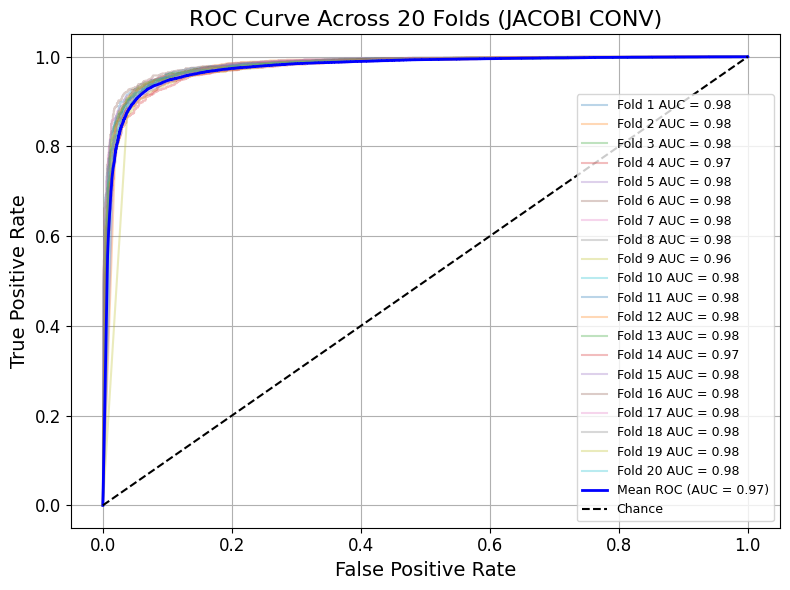

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curves for each fold
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (JACOBI CONV)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_input = X_tensor.cpu().numpy()
tsne_input = TSNE(n_components=2, init='pca', random_state=42)
input_2d = tsne_input.fit_transform(X_input)

model.eval()
with torch.no_grad():
    # Get final APPNP embeddings (after propagation)
    Z = model(X_tensor, edge_index).cpu().numpy()

tsne_embed = TSNE(n_components=2, init='pca', random_state=42)
embed_2d = tsne_embed.fit_transform(Z)

labels = y_tensor.cpu().numpy()

colors = ['blue', 'red']
markers = ['o', 's']
class_names = ['CN', 'MCI']
font_size = 8

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot raw input t-SNE
for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[0].scatter(input_2d[idx, 0], input_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[0].set_title("Raw Input Features (APPNP CN vs MCI)", fontsize=font_size)
axes[0].set_xlabel("t-SNE 1", fontsize=font_size)
axes[0].set_ylabel("t-SNE 2", fontsize=font_size)
axes[0].tick_params(labelsize=font_size)

# Plot APPNP embeddings t-SNE
for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[1].scatter(embed_2d[idx, 0], embed_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[1].set_title("APPNP Embeddings (CN vs MCI)", fontsize=font_size)
axes[1].set_xlabel("t-SNE 1", fontsize=font_size)
axes[1].set_ylabel("t-SNE 2", fontsize=font_size)
axes[1].tick_params(labelsize=font_size)
axes[1].legend(fontsize=font_size, loc='best')

plt.tight_layout()
plt.savefig("tsne_appnp_comparison.png", dpi=300, bbox_inches='tight')
plt.show()